In [1]:
import torch
import rocket as rk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
root_path = "./test_cases/"
system_name = "6lzm"
free_flag = "R-free-flags"
testset_value = 1
device = "cuda:0"

tng_file = "{p}/{r}/{r}-tng_withrfree.mtz".format(p=root_path, r=system_name)
input_pdb = "{p}/{r}/{r}-pred-aligned.pdb".format(p=root_path, r=system_name)
true_pdb = "{p}/{r}/{r}_noalts.pdb".format(p=root_path, r=system_name)

In [3]:
phitrue = np.load(
    "{p}/{r}/{r}-phitrue-solvent{s}.npy".format(
        p=root_path, r=system_name, s=True
    )
)
Etrue = np.load(
    "{p}/{r}/{r}-Etrue-solvent{s}.npy".format(
        p=root_path, r=system_name, s=True
    )
)

In [4]:
sfc = rk.llg.structurefactors.initial_SFC(
    input_pdb,
    tng_file,
    "FP",
    "SIGFP",
    Freelabel=free_flag,
    device=device,
    testset_value=testset_value,
)

In [5]:
llgloss = rk.llg.targets.LLGloss(sfc, tng_file, device)

In [6]:
Ecalc, Fc = llgloss.compute_Ecalc(
    None,
    return_Fc=True,
    update_scales=True,
    added_chain=None,
)

### SigmaAs from True Model

In [7]:
sigmas = rk.llg.utils.sigmaA_from_model(
    Etrue,
    phitrue,
    Ecalc,
    Fc,
    llgloss.sfc.dHKL,
    llgloss.bin_labels,
)

In [8]:
llgloss.sigmaAs = sigmas

In [9]:
llgloss_true = llgloss.forward(None).item()

### SigmaAs from adam optimization

In [10]:
llgloss.init_sigmaAs(Ecalc, requires_grad=True)
sigmaA_init = [a.item() for a in llgloss.sigmaAs]
llgloss_init = llgloss.forward(None).item()

In [11]:
llgloss.refine_sigmaA_adam(Ecalc, sub_ratio=0.95)
sigmaA_refined = [a.item() for a in llgloss.sigmaAs]
llgloss_refined = llgloss.forward(None).item()

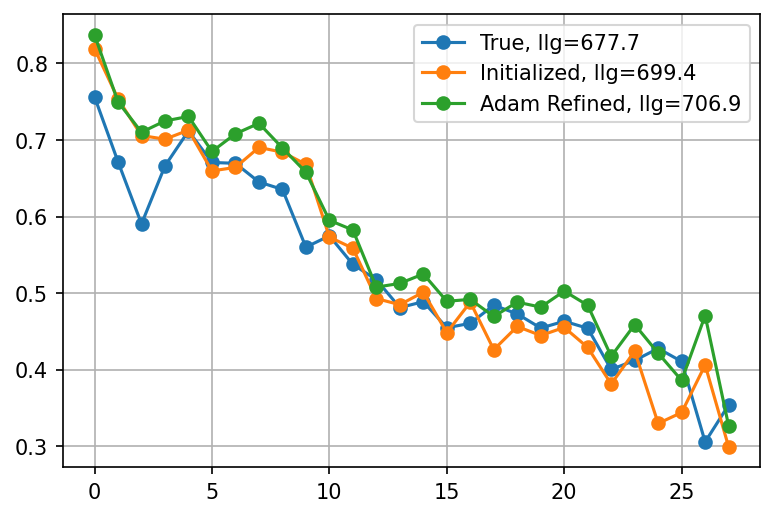

In [12]:
plt.figure(dpi=150)
plt.plot(sigmas, "o-", label=f'True, llg={llgloss_true:.1f}')
plt.plot(sigmaA_init, "o-", label=f'Initialized, llg={llgloss_init:.1f}')
plt.plot(sigmaA_refined, "o-", label=f'Adam Refined, llg={llgloss_refined:.1f}')
plt.legend()
plt.grid(visible="both")
plt.show()

### Dev analytical newton method for llg term

In [13]:
llgloss.init_sigmaAs(Ecalc, requires_grad=True)

In [7]:
from rocket.llg.utils import llgIa_firstdev, llgIa_seconddev, llgIc_firstdev, llgIc_seconddev, llgItot_calculate

In [8]:
def llgItot_firstdev(sigmaA, dobs, Eeff, Ec, centric_tensor):
    llgIp_centric = llgIc_firstdev(
        sigmaA, dobs[centric_tensor], Eeff[centric_tensor], Ec[centric_tensor]
    )
    llgIp_acentric = llgIa_firstdev(
        sigmaA, dobs[~centric_tensor], Eeff[~centric_tensor], Ec[~centric_tensor]
    )
    return llgIp_centric.sum() + llgIp_acentric.sum()

def llgItot_seconddev(sigmaA, dobs, Eeff, Ec, centric_tensor):
    llgIpp_centric = llgIc_seconddev(
        sigmaA, dobs[centric_tensor], Eeff[centric_tensor], Ec[centric_tensor]
    )
    llgIpp_acentric = llgIa_seconddev(
        sigmaA, dobs[~centric_tensor], Eeff[~centric_tensor], Ec[~centric_tensor]
    )
    return llgIpp_centric.sum() + llgIpp_acentric.sum()

In [9]:
free_set = (llgloss.sfc.free_flag) & (~llgloss.sfc.Outlier)

In [46]:
# Use all working set
LLG_traces = []
ds_traces = []
sigmaA_traces = []
for i, label in enumerate(tqdm(llgloss.unique_bins)):
    subset = llgloss.working_set
    index_i = llgloss.bin_labels[subset] == label
    Ecalc_i = Ecalc[subset][index_i]
    Eob_i = llgloss.Eobs[subset][index_i]
    Centric_i = llgloss.Centric[subset][index_i]
    Dobs_i = llgloss.Dobs[subset][index_i]
    sigmaA_i = llgloss.sigmaAs[i]
    # Newton method
    LLG_trace = []
    ds_trace = []
    sigmaA_trace = []
    for i in range(200):
        l = llgItot_calculate(sigmaA_i, Dobs_i, Eob_i, Ecalc_i, Centric_i)
        lp = llgItot_firstdev(sigmaA_i, Dobs_i, Eob_i, Ecalc_i, Centric_i)
        lpp = llgItot_seconddev(sigmaA_i, Dobs_i, Eob_i, Ecalc_i, Centric_i)
        ds = lp/lpp
        # print(f"LLG: {l:.2f}, dLLG/ds: {lp:.2f}, d2LLG/ds2: {lpp:.2f}, sigmaA:{sigmaA_i:.2f}, ds: {ds:.4f}")
        sigmaA_i = sigmaA_i + ds
        LLG_trace.append(l.item())
        ds_trace.append(ds.item())
        sigmaA_trace.append(sigmaA_i.item())
    LLG_traces.append(LLG_trace)
    ds_traces.append(ds_trace)
    sigmaA_traces.append(sigmaA_trace)

100%|██████████| 28/28 [00:32<00:00,  1.18s/it]


In [51]:
i = 10
label = llgloss.unique_bins[i]
subset = llgloss.working_set
index_i = llgloss.bin_labels[subset] == label
Ecalc_i = Ecalc[subset][index_i]
Eob_i = llgloss.Eobs[subset][index_i]
Centric_i = llgloss.Centric[subset][index_i]
Dobs_i = llgloss.Dobs[subset][index_i]

ls = []
for sA in np.linspace(0.0015, 0.99, 50):
    l = llgItot_calculate(sA, Dobs_i, Eob_i, Ecalc_i, Centric_i)
    ls.append(l.item())

In [59]:
l_init

29.019746780395508

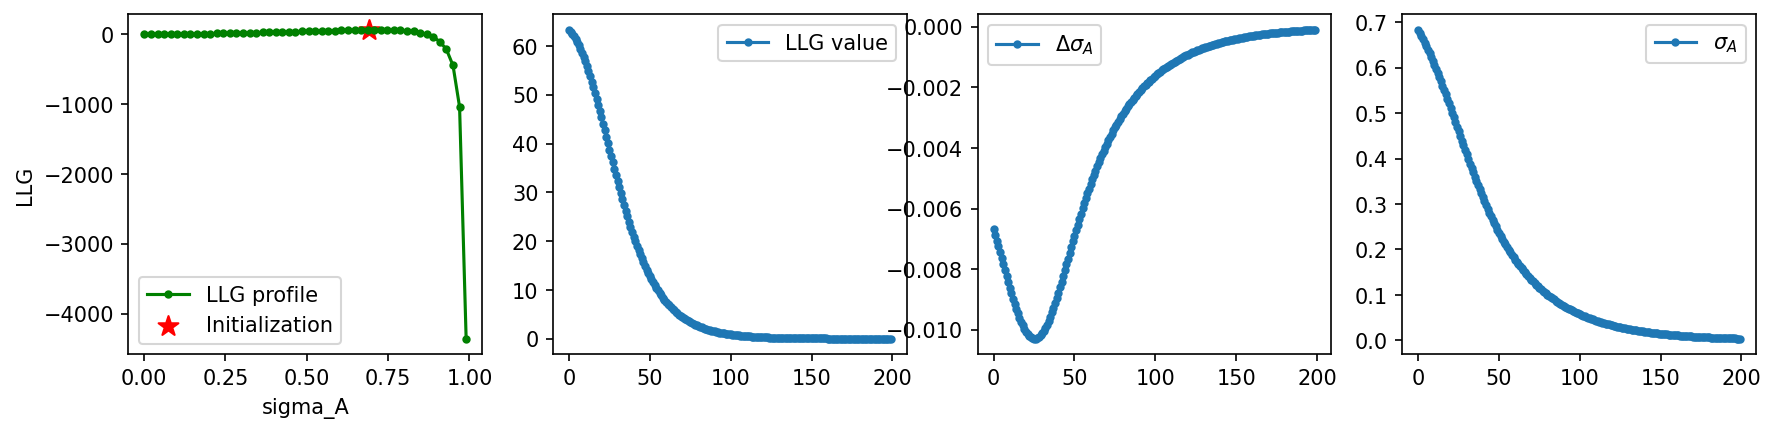

In [80]:
i = 7
label = llgloss.unique_bins[i]
subset = llgloss.working_set
index_i = llgloss.bin_labels[subset] == label
Ecalc_i = Ecalc[subset][index_i]
Eob_i = llgloss.Eobs[subset][index_i]
Centric_i = llgloss.Centric[subset][index_i]
Dobs_i = llgloss.Dobs[subset][index_i]

ls = []
for sA in np.linspace(0.0015, 0.99, 50):
    l = llgItot_calculate(sA, Dobs_i, Eob_i, Ecalc_i, Centric_i)
    ls.append(l.item())

l_init = llgItot_calculate(llgloss.sigmaAs[i], Dobs_i, Eob_i, Ecalc_i, Centric_i).item()
fig, ax = plt.subplots(1, 4, figsize=[14,3], dpi=150)
ax[0].plot(np.linspace(0.0015, 0.99, 50), ls, 'g.-', label='LLG profile')
ax[0].scatter(llgloss.sigmaAs[i].item(), l_init, marker = "*", color='r', s=100, label='Initialization')
ax[0].set_xlabel(r'sigma_A')
ax[0].set_ylabel(r'LLG')
ax[0].legend()
ax[1].plot(LLG_traces[i], '.-', label='LLG value')
ax[1].legend()
ax[2].plot(ds_traces[i], '.-', label=r'$\Delta \sigma_A$')
ax[2].legend()
ax[3].plot(sigmaA_traces[i], '.-', label=r'$\sigma_A$')
ax[3].legend()
plt.show()

#### Investigate the derivative value

In [10]:
llgloss.init_sigmaAs(Ecalc)

In [11]:
i = 0
label = llgloss.unique_bins[i]
subset = llgloss.working_set
index_i = llgloss.bin_labels[subset] == label
Ecalc_i = Ecalc[subset][index_i]
Eob_i = llgloss.Eobs[subset][index_i]
Centric_i = llgloss.Centric[subset][index_i]
Dobs_i = llgloss.Dobs[subset][index_i]

ls = []
lps_ana = []
lpps_ana = []
lps_ad = []
lpps_ad = []
l_init = llgItot_calculate(llgloss.sigmaAs[i], Dobs_i, Eob_i, Ecalc_i, Centric_i).item()
for sA in np.linspace(0.0015, 0.99, 50):
    sA = torch.tensor(sA, device='cuda:0', requires_grad=True)
    l = llgItot_calculate(sA, Dobs_i.detach(), Eob_i.detach(), Ecalc_i.detach(), Centric_i.detach())
    lp_ana = llgItot_firstdev(sA, Dobs_i.detach(), Eob_i.detach(), Ecalc_i.detach(), Centric_i.detach())
    lpp_ana = llgItot_seconddev(sA, Dobs_i.detach(), Eob_i.detach(), Ecalc_i.detach(), Centric_i.detach())
    lp_ad = torch.autograd.grad(l, sA, create_graph=True)[0]
    lpp_ad = torch.autograd.grad(lp_ad, sA, create_graph=True, allow_unused=True)[0]
    ls.append(l.item())
    lps_ana.append(lp_ana.item())
    lpps_ana.append(lpp_ana.item())
    lps_ad.append(lp_ad.item())
    lpps_ad.append(lpp_ad.item())

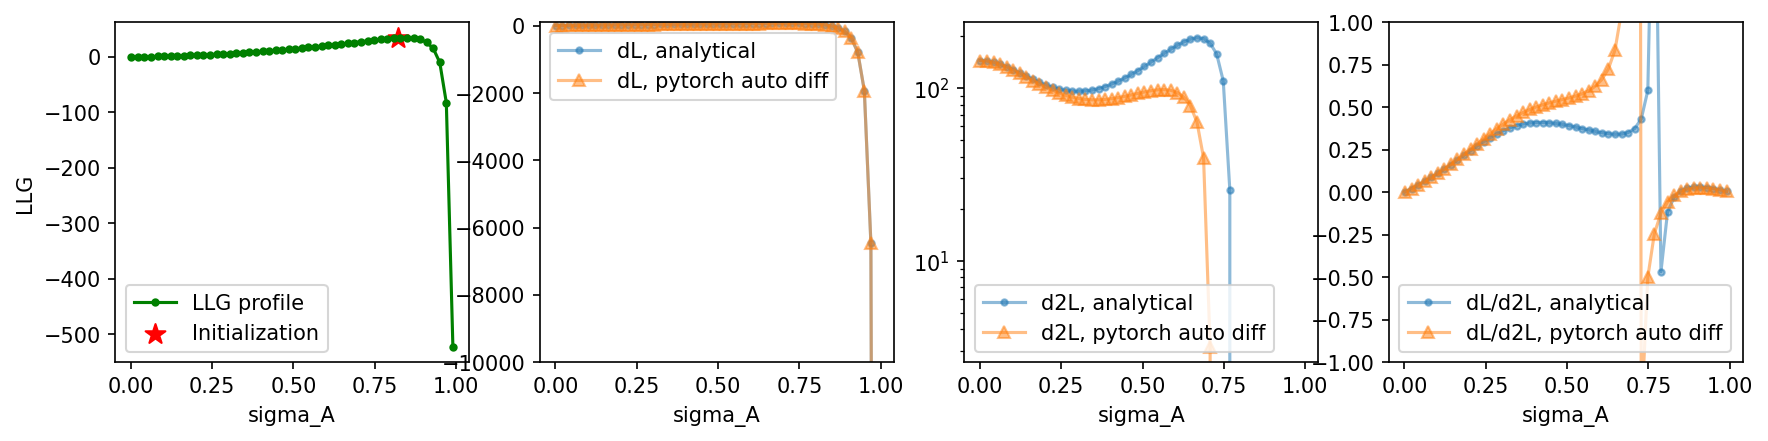

In [12]:
fig, ax = plt.subplots(1, 4, figsize=[14,3], dpi=150)
ax[0].plot(np.linspace(0.0015, 0.99, 50), ls, 'g.-', label='LLG profile')
ax[0].scatter(llgloss.sigmaAs[i].item(), l_init, marker = "*", color='r', s=100, label='Initialization')
ax[0].set_xlabel(r'sigma_A')
ax[0].set_ylabel(r'LLG')
ax[0].legend()
ax[1].plot(np.linspace(0.0015, 0.99, 50), lps_ana, '.-', label='dL, analytical', alpha=0.5)
ax[1].plot(np.linspace(0.0015, 0.99, 50), lps_ad, '^-', label='dL, pytorch auto diff', alpha=0.5)
ax[1].set_xlabel(r'sigma_A')
ax[1].set_ylim(-10000, 100)
#ax[1].set_yscale('log')
ax[1].legend()
ax[2].plot(np.linspace(0.0015, 0.99, 50), lpps_ana, '.-', label='d2L, analytical', alpha=0.5)
ax[2].plot(np.linspace(0.0015, 0.99, 50), lpps_ad, '^-', label='d2L, pytorch auto diff', alpha=0.5)
ax[2].set_xlabel(r'sigma_A')
#ax[2].set_ylim(1, 100000)
ax[2].set_yscale('log')
ax[2].legend()

ax[3].plot(np.linspace(0.0015, 0.99, 50), np.array(lps_ana)/np.array(lpps_ana), '.-', label='dL/d2L, analytical', alpha=0.5)
ax[3].plot(np.linspace(0.0015, 0.99, 50), np.array(lps_ad)/np.array(lpps_ad), '^-', label='dL/d2L, pytorch auto diff', alpha=0.5)
ax[3].set_xlabel(r'sigma_A')
ax[3].set_ylim(-1,1.0)
#ax[3].set_yscale('log')
ax[3].legend()
plt.show()

#### Use autodiff derivatives for newton method

In [123]:
# Use all working set
LLG_traces = []
ds_traces = []
sigmaA_traces = []
llgloss.init_sigmaAs(Ecalc)
for i, label in enumerate(tqdm(llgloss.unique_bins)):
    subset = llgloss.working_set
    index_i = llgloss.bin_labels[subset] == label
    Ecalc_i = Ecalc[subset][index_i]
    Eob_i = llgloss.Eobs[subset][index_i]
    Centric_i = llgloss.Centric[subset][index_i]
    Dobs_i = llgloss.Dobs[subset][index_i]
    sigmaA_i = llgloss.sigmaAs[i]
    # Newton method
    LLG_trace = []
    ds_trace = []
    sigmaA_trace = []
    for i in range(200):
        sA = sigmaA_i.clone().detach().requires_grad_(True)
        l = llgItot_calculate(sA, Dobs_i, Eob_i, Ecalc_i, Centric_i)
        lp = torch.autograd.grad(l, sA, create_graph=True)[0]
        lpp = torch.autograd.grad(lp, sA, create_graph=True, allow_unused=True)[0]
        ds = 0.01 * lp.item()/lpp.item()
        # print(f"LLG: {l:.2f}, dLLG/ds: {lp:.2f}, d2LLG/ds2: {lpp:.2f}, sigmaA:{sigmaA_i:.2f}, ds: {ds:.4f}")
        sigmaA_i = sigmaA_i + ds
        LLG_trace.append(l.item())
        ds_trace.append(ds)
        sigmaA_trace.append(sigmaA_i.item())
    LLG_traces.append(LLG_trace)
    ds_traces.append(ds_trace)
    sigmaA_traces.append(sigmaA_trace)

100%|██████████| 28/28 [00:28<00:00,  1.02s/it]


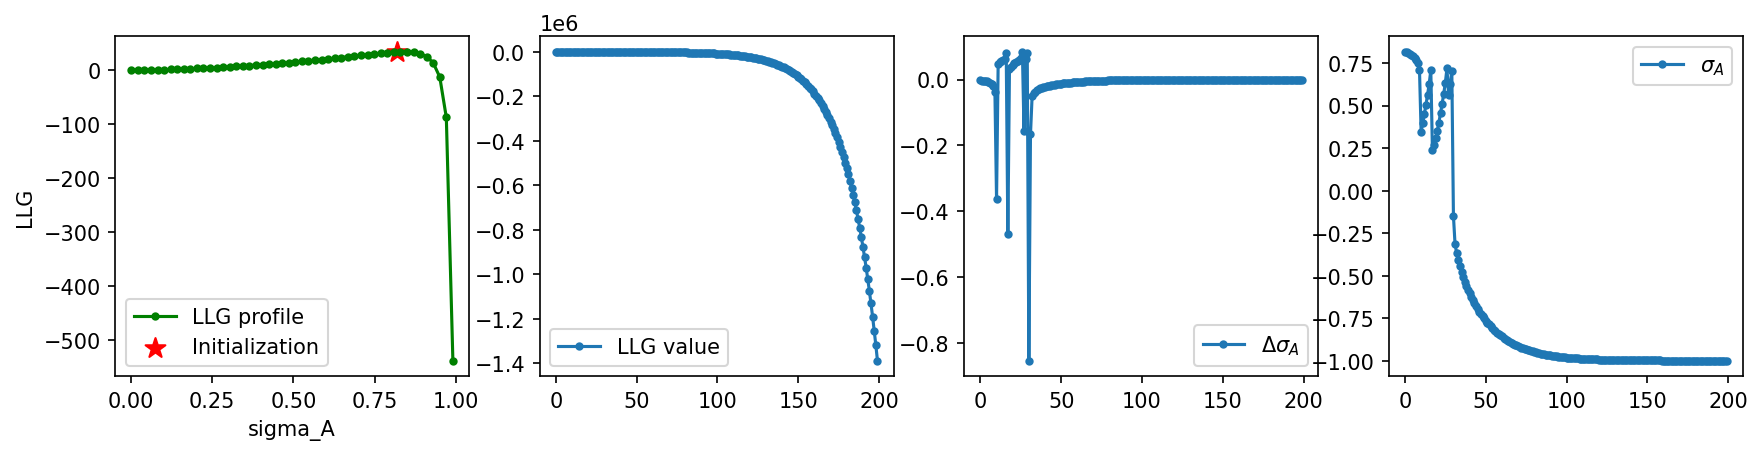

In [122]:
i = 0
label = llgloss.unique_bins[i]
subset = llgloss.working_set
index_i = llgloss.bin_labels[subset] == label
Ecalc_i = Ecalc[subset][index_i]
Eob_i = llgloss.Eobs[subset][index_i]
Centric_i = llgloss.Centric[subset][index_i]
Dobs_i = llgloss.Dobs[subset][index_i]

ls = []
for sA in np.linspace(0.0015, 0.99, 50):
    l = llgItot_calculate(sA, Dobs_i, Eob_i, Ecalc_i, Centric_i)
    ls.append(l.item())

l_init = llgItot_calculate(llgloss.sigmaAs[i], Dobs_i, Eob_i, Ecalc_i, Centric_i).item()
fig, ax = plt.subplots(1, 4, figsize=[14,3], dpi=150)
ax[0].plot(np.linspace(0.0015, 0.99, 50), ls, 'g.-', label='LLG profile')
ax[0].scatter(llgloss.sigmaAs[i].item(), l_init, marker = "*", color='r', s=100, label='Initialization')
ax[0].set_xlabel(r'sigma_A')
ax[0].set_ylabel(r'LLG')
ax[0].legend()
ax[1].plot(LLG_traces[i], '.-', label='LLG value')
ax[1].legend()
ax[2].plot(ds_traces[i], '.-', label=r'$\Delta \sigma_A$')
ax[2].legend()
ax[3].plot(sigmaA_traces[i], '.-', label=r'$\sigma_A$')
ax[3].legend()
plt.show()

#### Device debug

In [22]:
llgIp_centric = llgIc_firstdev(
    sigmaA_i, Dobs_i[Centric_i], Eob_i[Centric_i], Ecalc_i[Centric_i]
)

In [23]:
llgIp_centric

tensor([ 0.4915,  1.3503, -0.4796,  0.7799,  0.4888, -2.7817,  0.5893, -0.0129,
         0.6690,  2.0449,  0.8685,  0.4414,  0.0636, -0.4359,  0.2675, -0.7439,
         1.7024,  0.1800,  1.8346,  1.8874,  0.4442,  0.0804,  0.2919,  0.4315,
        -0.0985,  1.1768,  1.2622,  0.8838,  1.1532,  0.5517,  0.7941,  0.3203,
         0.8748,  1.4934, -0.6261, -0.0602,  1.1505,  0.4174,  1.8409,  0.9933],
       device='cuda:0', grad_fn=<DivBackward0>)

In [24]:
llgIp_acentric = llgIa_firstdev(
    sigmaA_i, Dobs_i[Centric_i], Eob_i[Centric_i], Ecalc_i[Centric_i]
)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [25]:
bessel_argument = (2 * Dobs_i[Centric_i] * Ecalc_i[Centric_i] * Eob_i[Centric_i] * sigmaA_i) / (1 - Dobs_i[Centric_i]**2 * sigmaA_i**2)

In [52]:
bessel_argument

tensor([0.1589, 0.0416, 0.3776, 0.2784, 0.7121, 0.5297, 0.1678, 1.7274, 2.0271,
        5.7809, 0.1296, 1.4101, 0.5365, 0.3521, 0.8277, 1.3625, 4.6776, 0.6180,
        4.7585, 4.9967, 0.7904, 0.6327, 1.7331, 1.5145, 1.0100, 0.1140, 3.2599,
        2.8010, 0.0942, 0.3655, 0.0531, 0.0454, 0.2583, 3.7626, 3.9623, 0.8746,
        0.0938, 5.5090, 6.1672, 2.5794], device='cuda:0',
       grad_fn=<DivBackward0>)

In [44]:
l = llgItot_calculate(sigmaA_i, Dobs_i, Eob_i, Ecalc_i, Centric_i)

In [45]:
l

tensor(27.8631, device='cuda:0', grad_fn=<AddBackward0>)

#### Continue